# Aprendizaje por refuerzo para encontrar políticas

Esta libreta resuelve algunos ejercicios del libro de Aprendizaje por Refuerzo de Sutton y Barto. Es una traducción del código en Python utilizado para dibujar las gráficas usadas en el libro.

Para leer una explicación más a fondo de los algoritmos usados aquí, por favor lee la [siguiente página](https://rexemin.github.io/Topicos-IA-UNISON/2018/11/30/ejercicios-sutton-barto.html).

In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [52]:
import Distributions
import Plots
Plots.pyplot()

Plots.PyPlotBackend()

# Windy Grid World

En este problema, se debe entrenar un agente para que pueda recorrer una cuadrícula en donde existen corrientes de viento que lo empujan en una dirección particular.

En la siguiente celda se definen variables que describen el entorno y los parámetros del algoritmo de aprendizaje.

### Entorno

Es una cuadrícula de 10x7 cuadros. En las columnas 4, 5, 6, 9 existe una corriente de viento leve, mientras que en las columnas 7 y 8 hay corrientes más fuertes.

El agente comienza en la coordenada $(4, 1)$ y debe dirigirse lo más pronto posible a la meta ubicada en la coordenada $(4, 8)$. En cualquier coordenada puede decidir moverse en las 4 direcciones cardinales.

In [3]:
world_height = 7
world_width = 10
wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

ACTION_UP = 1
ACTION_DOWN = 2
ACTION_LEFT = 3
ACTION_RIGHT = 4

ϵ = 0.1
α = 0.5
reward = -1.0

start = [4, 1]
goal = [4, 8]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

4-element Array{Int64,1}:
 1
 2
 3
 4

### Pasos dentro de un mismo episodio

Cada vez que el agente decide moverse en alguna dirección, se interpreta como un paso en el episodio actual de la simulación. Aquí es donde se toma en cuenta el efecto de las corrientes de viento.

In [4]:
function ep_step(state, action)
    i, j = state
    
    if action == ACTION_UP
        return [max(i - 1 - wind[j], 1), j]
    elseif action == ACTION_DOWN
        return [max(min(i + 1 - wind[j], world_height), 1), j]
    elseif action == ACTION_LEFT
        return [max(i - wind[j], 1), max(j - 1, 1)]
    elseif action == ACTION_RIGHT
        return [max(i - wind[j], 1), min(j + 1, world_width)]
    else
        return ErrorException("You can't do that!")
    end
end

ep_step (generic function with 1 method)

### Episodios

Un episodio dura desde el primer movimiento del agente hasta que llega a la meta. En cada episodio se mide cuanto tiempo (movimientos) necesita para llegar a la coordenada meta.

Para aprender, se usa el algoritmo SARSA junto con una política $\epsilon$-greedy para decidir qué acciones tomar.

In [5]:
function episode(q_value)
    time_ = 0
    state = start

    if rand(Distributions.Binomial(1, ϵ)) == 1
        action = rand(actions)
    else
        values_ = q_value[state[1], state[2], :]
        action = rand([action_ for (action_, value_) in enumerate(values_) if value_ == maximum(values_)])
    end

    while state != goal
        next_state = ep_step(state, action)
        
        if rand(Distributions.Binomial(1, ϵ)) == 1
            next_action = rand(actions)
        else
            values_ = q_value[next_state[1], next_state[2], :]
            next_action = rand([action_ for (action_, value_) in enumerate(values_) if value_ == maximum(values_)])
        end
        
        # Sarsa update
        q_value[state[1], state[2], action] += 
            α * (reward + q_value[next_state[1], next_state[2], next_action] -
                         q_value[state[1], state[2], action])
        state = next_state
        action = next_action
        time_ += 1
    end
    
    return time_
end

episode (generic function with 1 method)

Creamos las variables que faltan para poder ejecutar el algoritmo en el entorno.

In [6]:
q_value = zeros((world_height, world_width, 4))
episode_limit = 500

steps = []
ep = 0

while ep < episode_limit
    append!(steps, episode(q_value))
    ep += 1
end

steps = accumulate(+, steps)

500-element Array{Any,1}:
   309
  1187
  1607
  1675
  1756
  1885
  1933
  2043
  2118
  2246
  2375
  2431
  2483
     ⋮
 14664
 14682
 14704
 14722
 14743
 14761
 14777
 14796
 14816
 14832
 14851
 14870

En la siguiente gráfica podemos ver como es que mientras más avanzó el aprendizaje, más episodios se resolvían rápidamente al incrementar el número de pasos permitidos.

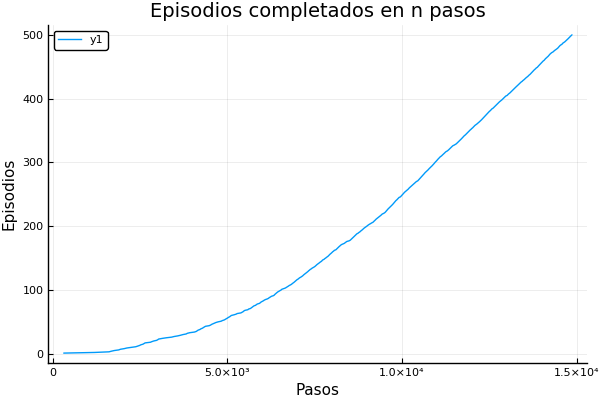

In [9]:
Plots.plot(steps, [a for a ∈ range(1, length(steps))],
    title = "Episodios completados en n pasos")
Plots.xlabel!("Pasos")
Plots.ylabel!("Episodios")

Por último, podemos ver la política óptima encontrada por el algoritmo.

In [10]:
optimal_policy = []

for i in range(1, world_height)
    push!(optimal_policy, [])
    
    for j in range(1, world_width)
        if [i, j] == goal
            append!(optimal_policy[end],"G")
            continue
        end
        
        bestAction = argmax(q_value[i, j, :])
        
        if bestAction == ACTION_UP
            append!(optimal_policy[end], "U")
        elseif bestAction == ACTION_DOWN
            append!(optimal_policy[end], "D")
        elseif bestAction == ACTION_LEFT
            append!(optimal_policy[end], "L")
        elseif bestAction == ACTION_RIGHT
            append!(optimal_policy[end], "R")
        end
    end
end

println("Optimal policy is:")
for row in optimal_policy
    println(row)
end

Optimal policy is:
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
Any['U', 'U', 'R', 'U', 'R', 'R', 'U', 'R', 'R', 'D']
Any['R', 'D', 'R', 'R', 'R', 'U', 'R', 'G', 'R', 'D']
Any['R', 'R', 'R', 'R', 'D', 'R', 'U', 'D', 'L', 'L']
Any['D', 'D', 'R', 'R', 'R', 'U', 'U', 'D', 'R', 'U']
Any['U', 'L', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'L']


# Cliff Walking

En este problema, el agente debe aprender a navegar una cuadrícula de 12x4 cuadros, en donde las coordenadas horizontales que van desde $(2, 1)$ a $(11, 1)$ representan un abismo, por el cual el agente es penalizado con una recompensa de -100 y regresado a la coordenada inicial.

El agente puede moverse en las 4 direcciones cardinales en cada punto. Cada vez que se mueve, se le da una recompensa de -1 si no llega a la meta.

La coordenada inicial es $(4, 1)$.

In [11]:
world_height = 4
world_width = 12

ϵ = 0.1
α = 0.5
γ = 1

ACTION_UP = 1
ACTION_DOWN = 2
ACTION_LEFT = 3
ACTION_RIGHT = 4

actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

start = [4, 1]
goal = [4, 12]

2-element Array{Int64,1}:
  4
 12

### Pasos en los episodios

Un paso en un episodio en este entorno se da cada vez que el agente se mueve. Primero se obtiene la coordenada a la que decidió desplazarse y luego se revisa si cayó al abismo.

In [12]:
function ep_step(state, action)
    i, j = state
    
    if action == ACTION_UP
        next_state = [max(i - 1, 1), j]
    elseif action == ACTION_LEFT
        next_state = [i, max(j - 1, 1)]
    elseif action == ACTION_RIGHT
        next_state = [i, min(j + 1, world_width)]
    elseif action == ACTION_DOWN
        next_state = [min(i + 1, world_height), j]
    else
        return ErrorException("You can't do that!")
    end

    reward = -1
    if (action == ACTION_DOWN && i == 3 && 2 <= j <= 11) ||
        (action == ACTION_RIGHT && state == start)
        reward = -100
        next_state = start
    end

    return next_state, reward
end

ep_step (generic function with 1 method)

Las acciones también se toman a través del uso de una política $\epsilon$-greedy.

In [13]:
function choose_action(state, q_value)
    if rand(Distributions.Binomial(1, ϵ)) == 1
        return rand(actions)
    else
        values_ = q_value[state[1], state[2], :]
    end
    
    return rand([action_ for (action_, value_) ∈ enumerate(values_) if value_ == maximum(values_)])
end

choose_action (generic function with 1 method)

En las siguientes celdas está el código de los dos algoritmos de aprendizaje usados: **SARSA** y **Q-Learning**. Más adelante compararemos los resultados que da cada uno.

In [14]:
function sarsa(q_value, step_size = α)
    state = start
    action = choose_action(state, q_value)
    rewards = 0.0
    
    while state != goal
        next_state, reward = ep_step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        
        target = q_value[next_state[1], next_state[2], next_action]
        target *= γ
        
        q_value[state[1], state[2], action] += step_size * 
        (reward + target - q_value[state[1], state[2], action])
        
        state = next_state
        action = next_action
    end
                
    return rewards
end

sarsa (generic function with 2 methods)

In [15]:
function q_learning(q_value, step_size = α)
    state = start
    rewards = 0.0
    
    while state != goal
        action = choose_action(state, q_value)
        next_state, reward = ep_step(state, action)
        rewards += reward
        
        q_value[state[1], state[2], action] += step_size * 
        (reward + γ * maximum(q_value[next_state[1], next_state[2], :]) - q_value[state[1], state[2], action])
        
        state = next_state
    end
    
    return rewards
end

q_learning (generic function with 2 methods)

La siguiente celda solo es una función que nos muestra las políticas óptimas encontradas por un algoritmo de aprendizaje. Es análogo al código presentado en el problema anterior.

In [16]:
function print_optimal_policy(q_value)
    optimal_policy = []
    
    for i in range(1, stop=world_height)
        push!(optimal_policy,[])
        
        for j in range(1, stop=world_width)
            if [i, j] == goal
                append!(optimal_policy[end], 'G')
                continue
            end
            
            bestAction = argmax(q_value[i, j, :])
            
            if bestAction == ACTION_UP
                append!(optimal_policy[end], 'U')
            elseif bestAction == ACTION_DOWN
                append!(optimal_policy[end], 'D')
            elseif bestAction == ACTION_LEFT
                append!(optimal_policy[end], 'L')
            elseif bestAction == ACTION_RIGHT
                append!(optimal_policy[end], 'R')
            end
        end
    end
    
    for row in optimal_policy
        println(row)
    end
end

print_optimal_policy (generic function with 1 method)

En la siguiente celda se ejecutan ambos algoritmos varias veces.

In [17]:
episodes = 500
runs = 50

rewards_sarsa = zeros(episodes)
rewards_q_learning = zeros(episodes)
q_sarsa = zeros((world_height, world_width, 4))
q_q_learning = deepcopy(q_sarsa)

for r ∈ range(1, runs)
    q_sarsa = zeros((world_height, world_width, 4))
    q_q_learning = deepcopy(q_sarsa)

    for i ∈ range(1, episodes)
        rewards_sarsa[i] += sarsa(q_sarsa)
        rewards_q_learning[i] += q_learning(q_q_learning)
    end
end

rewards_sarsa /= runs
rewards_q_learning /= runs

500-element Array{Float64,1}:
 -1750.34
  -323.56
  -194.24
  -140.88
  -129.02
  -121.44
  -146.94
  -112.78
  -105.48
   -97.4 
   -91.64
   -94.38
   -89.96
     ⋮   
   -40.34
   -35.52
   -41.68
   -37.18
   -64.72
   -61.88
   -29.2 
   -42.16
   -61.1 
   -44.24
   -60.68
   -28.64

### Comparación

En la siguiente gráfica podemos ver como el algoritmo de Q-Learning logra peores recompensas que SARSA. Si revisamos las políticas encontradas, veremos que la política de Q-Learning prefiere arriesgarse por la ruta óptima (justo por encima del abismo), pero la toma de acciones $\epsilon$-greedy provoca que a veces caiga.

Por su parte, SARSA prefiere irse por una ruta más segura.

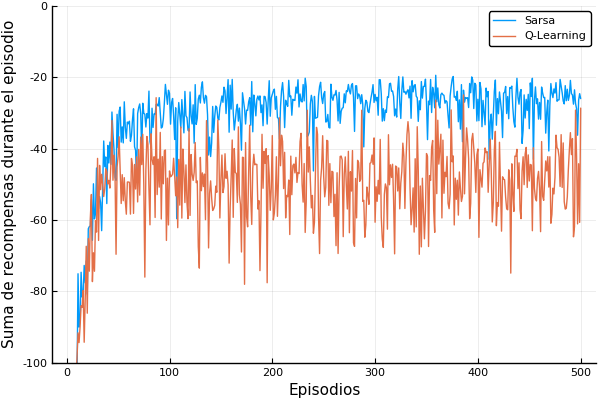

In [18]:
Plots.plot(rewards_sarsa, label = "Sarsa", xlabel = "Episodios", ylabel = "Suma de recompensas durante el episodio")
Plots.plot!(rewards_q_learning, label = "Q-Learning", ylim = (-100, 0))

In [20]:
println("Sarsa Optimal Policy:")
print_optimal_policy(q_sarsa)
println("Q-Learning Optimal Policy:")
print_optimal_policy(q_q_learning)

Sarsa Optimal Policy:
Any['R', 'R', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
Any['R', 'R', 'R', 'R', 'R', 'U', 'U', 'L', 'U', 'L', 'R', 'D']
Any['U', 'U', 'U', 'U', 'R', 'U', 'R', 'U', 'U', 'U', 'R', 'D']
Any['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
Any['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
Any['D', 'D', 'D', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'R', 'D']
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


# Mountain Car

![mountain.png](mountain.png)

En este tercer y último entorno, el agente debe aprender a acelerar de la manera correcta para sacar un carro de un hoyo.

El agente solo tiene 3 acciones:
    1. Acelerar a la derecha
    2. Acelerar a la izquierda
    3. No hacer algo
    
El entorno es continuo en 2 dimensiones en este problema, por lo que debemos aproximarlo para poderlo tratar. Para esta tarea usaremos Tile Coding.

In [1]:
using PyCall
import Plots
import Base.count
Plots.pyplot();

### Tile coding

Para codificar el tile coding, utilizaremos una función hash que nos permita construir un diccionario donde cada llave nos permita agrupar coordenadas suficientemente cercanas entre sí.

Un agradecimiento a mi compañero [Fernando](https://github.com/fsr313) por ayudarme con esta parte.

In [66]:
mutable struct IHT
    size::Int64
    overfull_count::Int64
    dictionary::Dict{Any,Any}
    IHT(x) = new(x, 0, Dict{Any,Any}())
end

Las siguientes dos funciones auxiliares nos permitirán revisar si el hash se llena y tendremos que manejar colisiones.

In [67]:
function count(x::IHT)
    return length(x.dictionary)
end

function full(x::IHT)
    return length(x.dictionary >= x.size)
end

full (generic function with 1 method)

Las siguientes dos funciones construirán y accederán al diccionario de nuestros hashes para las coordenadas del carro.

In [68]:
function get_index(x::IHT,obj,read_only = false)
    dic = x.dictionary
    
    if haskey(dic, obj)
        return dic[obj]
    elseif read_only
        return
    end
    
    size = x.size
    counts = count(x)
    
    if counts >= size
        if x.overfull_count == 0
            println("IHT is full, starting to allow collisions")
        end
        
        x.overfull_count += 1
        return pybuiltin(:hash)(obj) % x.size
    else
        dic[obj] = counts
        return counts
    end
end

function hash_coords(coordinates, m, read_only = false)
    if m isa IHT
        return get_index(m, tuple(coordinates), read_only)
    elseif m isa Number
        return pybuiltin(:hash)(tuple(coordinates)) % m
    else    
        return coordinates
    end
end

hash_coords (generic function with 2 methods)

La siguiente función es la que hace la magia del Tile Coding. Crea cada azulejo que estamos usando y relaciona las coordenadas que pasamos a estos azulejos.

In [69]:
function tiles(iht_or_size, num_tilings, floats, ints = false, read_only = false)
    if ints == false
        ints = []
    end
    
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    
    for tiling ∈ 1:num_tilings
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        
        for q ∈ qfloats
            push!(coords, Int(floor((q + b) / num_tilings)))
            b += tilingX2
        end
        
        for i ∈ ints
            push!(coords, i)
        end
        
        for i ∈ hash_coords(coords, iht_or_size, read_only)
            push!(tiles, i + 1)
        end
    end
    
    return tiles
end

tiles (generic function with 3 methods)

## Aprendizaje

Ahora definiremos las funciones y las variables necesarias para ejecutar los algoritmos de aprendizaje.

In [70]:
ACTION_REVERSE = 1
ACTION_ZERO = 2
ACTION_FORWARD = 3

ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

ϵ = 0

0

### Pasos de un episodio

Cada vez que el agente decide actuar sobre el entorno, se calcula la velocidad y la posición del carro con las fórmulas físicas clásicas que se usan para esto.

In [71]:
function step_(position, velocity, action)
    new_velocity = velocity + 0.001 * action - 0.0025 * cos(3 * position)
    new_velocity = min(max(VELOCITY_MIN, new_velocity), VELOCITY_MAX)
    
    new_position = position + new_velocity
    new_position = min(max(POSITION_MIN, new_position), POSITION_MAX)
    
    reward = -1.0
    
    if new_position == POSITION_MIN
        new_velocity = 0.0
    end
    
    return new_position, new_velocity, reward
end

step_ (generic function with 1 method)

En las siguientes 3 celdas está el código que nos permitirá evaluar cómo va el agente, además de darle la capacidad de aprender.

In [72]:
mutable struct ValueFunction
    max_size
    num_of_tilings
    step_size
    hash_table
    weights
    position_scale
    velocity_scale

    function ValueFunction(step_size, num_of_tilings = 8, max_size = 2048)
        max_size = max_size
        num_of_tilings = num_of_tilings
        step_size = step_size / num_of_tilings
        hash_table = IHT(max_size)
        weights = zeros(max_size)
        position_scale = num_of_tilings / (POSITION_MAX - POSITION_MIN)
        velocity_scale = num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)
        new(max_size, num_of_tilings, step_size, hash_table, weights, position_scale, velocity_scale)
    end
end

In [73]:
function get_active_tiles(self::ValueFunction, position,velocity, action)
    active_tiles = tiles(self.hash_table,
        self.num_of_tilings,
        [self.position_scale * position, self.velocity_scale * velocity],
        [action])
    
    return active_tiles    
end

get_active_tiles (generic function with 1 method)

In [74]:
function value(self::ValueFunction, position, velocity, action)
    if position == POSITION_MAX
        return 0.0
    end
    
    active_tiles = get_active_tiles(self, position, velocity, action)
    return sum(self.weights[active_tiles])
end

function learn(self::ValueFunction, position, velocity, action, target)
    active_tiles = get_active_tiles(self, position, velocity, action)
    estimation = sum(self.weights[active_tiles])
    delta = self.step_size * (target - estimation)
    
    for active_tile ∈ active_tiles
        self.weights[active_tile] += delta
    end
end

function cost_to_go(self::ValueFunction, position, velocity)
    costs = []
    
    for action ∈ ACTIONS
        append!(costs, value(self, position, velocity, action))
    end
    
    return -maximum(costs)
end

cost_to_go (generic function with 1 method)

Para seleccionar una acción, aquí también se utiliza una política $\epsilon$-greedy.

In [75]:
function get_action(position, velocity, value_function)
    if rand(Distributions.Binomial(1, ϵ)) == 1
        action = ACTIONS[rand(1:length(ACTIONS))]
    end
    
    values = []
    
    for action ∈ ACTIONS
        push!(values, value(value_function, position, velocity, action))
    end
    
    choice = []
    
    for i ∈ enumerate(values)
        if i[2] == maximum(values)
            push!(choice, i[1])
        end
    end
    
    choice = choice[rand(1:length(choice))]
    return choice
end

get_action (generic function with 1 method)

### Episodios

Cada episodio dura una cantidad fija de tiempo, y el agente debe apurarse por salir. Utilizaremos una variante de SARSA.

In [76]:
function semi_gradient_n_step_sarsa(value_function, n = 1)
    current_position = rand() * (-.4 - (-.6)) -.6
    
    current_velocity = 0.0
    
    current_action = get_action(current_position, current_velocity, value_function)
    
    positions = [current_position]
    velocities = [current_velocity]
    actions = [current_action]
    rewards = [0.0]
    
    time = 1
    
    T = 12000
    
    while true
        time += 1
        
        if time < T
            new_position, new_velocity, reward = step_(current_position, current_velocity, current_action)
            new_action = get_action(new_position, new_velocity, value_function)
            
            push!(positions, new_position)
            push!(velocities, new_velocity)
            push!(actions, new_action)
            push!(rewards, reward)

            if new_position == POSITION_MAX
                T = time
            end
        end
        
        update_time = time - n
        
        if update_time >= 0
            returns = 0.0
            
            for t in (update_time):(min(T, update_time + n))
                returns += rewards[t]
            end
            
            if update_time + n <= T
                returns += value(value_function, positions[update_time + n], velocities[update_time + n], actions[update_time + n])
            end

            if positions[update_time] != POSITION_MAX
                learn(value_function,positions[update_time], velocities[update_time], actions[update_time], returns)
            end
        end
        
        if update_time == T - 1
            break
        end
        
        current_position = new_position
        current_velocity = new_velocity
        current_action = new_action
    end
    
    return time
end

semi_gradient_n_step_sarsa (generic function with 2 methods)

### Política aprendida

En las siguientes gráficas podemos ver como es que el agente aprende la función `cost_to_go`, que es realmente el `q_value` que vemos en los otros casos.

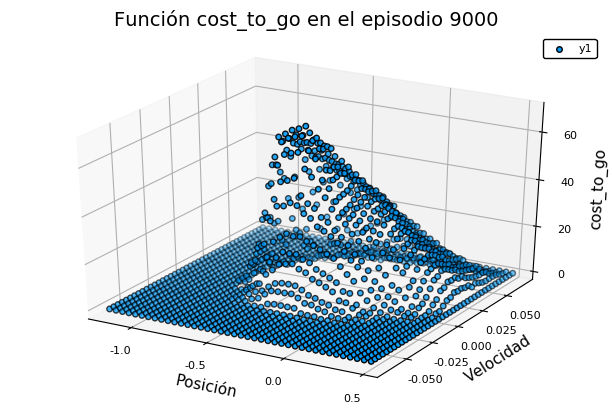

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [80]:
episodes = 9000
plot_episodes = [12, 104, 428, 1200, episodes/2, episodes]
num_of_tilings = 8
α = 0.3

value_function = ValueFunction(α, num_of_tilings)

for ep in 1:episodes
    semi_gradient_n_step_sarsa(value_function)
    
    if ep in plot_episodes
        grid_size = 40
        positions = range(POSITION_MIN, stop = POSITION_MAX, length = grid_size) |> collect
        velocities = range(VELOCITY_MIN, stop = VELOCITY_MAX, length = grid_size) |> collect
        
        axis_x = []
        axis_y = []
        axis_z = []
        
        for position in positions
            for velocity in velocities
                push!(axis_x, position)
                push!(axis_y, velocity)
                push!(axis_z, cost_to_go(value_function, position, velocity))
            end
        end
        
        Plots.scatter(axis_x, axis_y, axis_z, zaxis = "cost_to_go", title = ("Función cost_to_go en el episodio $(ep)"))
        Plots.xaxis!("Posición")
        Plots.yaxis!("Velocidad")
        Plots.savefig(string(ep))
    end
end

![12.png](12.png)
![104.png](104.png)
![428.png](428.png)
![1200.png](1200.png)
![4500.png](4500.png)